# Fitzhugh-Nagumo model

The Fitzhugh-Nagumo model of an excitable system is a two-dimensional simplification of the Hodgin-Huxley model of spike generation in squid giant axons

$$\frac{dv}{dt} = -f(v) + w + I_{app} $$

$$\frac{dw}{dt} = \epsilon\cdot(-v-\gamma w)$$

$$f(v) = v\cdot(v-1)\cdot(v-a)$$

Where Iapp is a stimulus current.

Characteristics of the model:
- The neuron cell is initally at a resting potential value.
- If we experimentally displace the potential a little bit, it returns to the resting value.
- If the perturbation is higher than a treshold value, the potential will shoot up to a very high value. In other words the spike will occur. After the spike the membrane will return to its resting value

## Model simulation (euler method)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
})

In [2]:
# Params
Iapp = 0
a = 0.14
gamma = 2.54
eps = 0.01

# Simulation parameters
dt = 0.01
n_iters = 10000

# Initial values
vo = -0.3
wo = -0.2

In [3]:
def f(v):
    return v*(v-1)*(v-a)

def run_fn(n_iters, dt, k):
    
    Iapp = k
    
    v = np.zeros(n_iters)
    w = np.zeros(n_iters)

    v[0] = vo
    w[0] = wo

    for i in range(n_iters-1):
        dvdt = -f(v[i])+w[i]+Iapp
        dwdt = eps*(-v[i]-gamma*w[i])

        v[i+1] = v[i]+dvdt*dt
        w[i+1] = w[i]+dwdt*dt
    
    return v,w

Temporal simulation

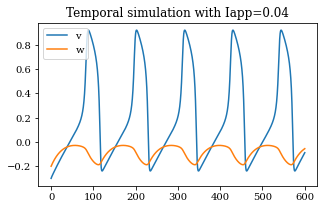

In [4]:
k = 0.04
dt = 0.01
n_iters = 60000

v,w = run_fn(n_iters, dt, k)

t = np.linspace(0,n_iters*dt,n_iters)

plt.figure(figsize=(5, 3))
plt.plot(t,v,label='v')
plt.plot(t,w,label='w')
plt.title(f'Temporal simulation with Iapp={k}')
plt.legend()
plt.show()

Phase diagram (w,v)

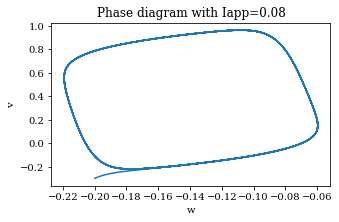

In [5]:
k = 0.08
dt = 0.01
n_iters = 60000

v,w = run_fn(n_iters, dt, k)

plt.figure(figsize=(5, 3))
plt.plot(w,v,label='v')
plt.title(f'Phase diagram with Iapp={k}')
plt.xlabel('w')
plt.ylabel('v')
plt.show()

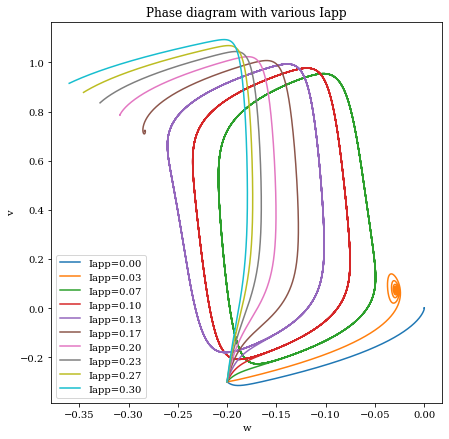

In [6]:
k = np.linspace(0,0.3,10)
dt = 0.01
n_iters = 60000
plt.figure(figsize=(7, 7))


for iapp in k:
    v,w = run_fn(n_iters, dt, iapp)
    plt.plot(w,v,label=f'Iapp={iapp:.2f}')

plt.title(f'Phase diagram with various Iapp')
plt.xlabel('w')
plt.ylabel('v')
plt.legend()
plt.show()

## scipy.odeInt implementation

In [7]:
from scipy.integrate import odeint
from functools import partial

In [8]:
def f(v, a):
    return v*(v-1)*(v-a)

def fitzhugh_nagumo(X, t, a, gamma, eps, Iapp):
    """Time derivative of FN model
    Args:
        X (float array 2): [Membrane potential (V), Recovery variable(W)]
        a, gamma (float): Model parameters
        t (float): Time (not used bc autonomous system)
        Iapp (float): Constant stimilus current
        eps (float): time scale
        
    """
    dvdt = -f(X[0],a)+X[1]+Iapp
    dwdt = eps*(-X[0]-gamma*X[1])
    
    return np.array([dvdt, dwdt])

In [9]:
def run_fc(param, t):
    ic = odeint(partial(fitzhugh_nagumo, **param), # nice way of unpacking elements in tuple
                y0 = [0,0],
                t = np.linspace(0,999,1000))[-1]
    
    lines = []
    
    for displacement in np.linspace(0,0.3,3):
        lines.append(odeint(partial(fitzhugh_nagumo, **param), # nice way of unpacking elements in tuple
                     y0 = ic + np.array([displacement, 0]),
                     t = t))
    
    return lines

**Temporal simulations**

Plot of different scenarios (parameters) and with an initial displacement.

In [19]:
scenarios = [
    { "a": +0.14, "gamma": 2.54, "eps": 0.01, "Iapp": 0 },
    { "a": +0.14, "gamma": 2.54, "eps": 0.01, "Iapp": 0.1 },
    { "a": +0.14, "gamma": 2.54, "eps": 0.01, "Iapp": 0.29}
]

time_span = np.linspace(0, 800, num=1500)

lines = {}
for i, scenario in enumerate(scenarios):
    lines[i] = run_fc(scenario, time_span)

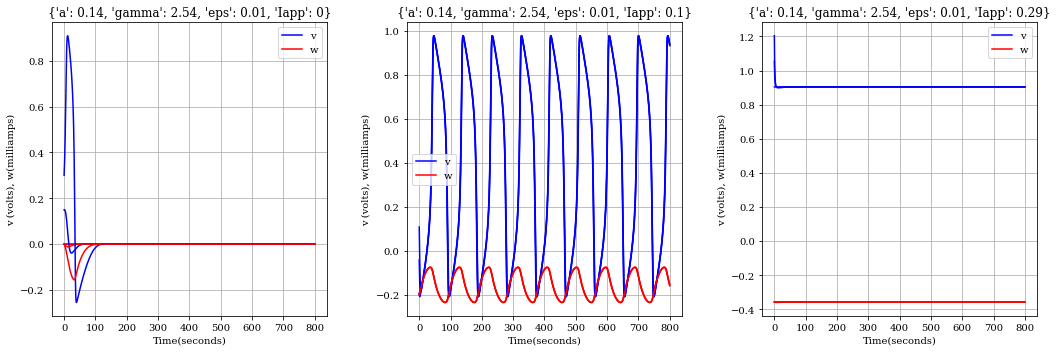

In [20]:
fig, ax = plt.subplots(1, len(scenarios), figsize=(5*len(scenarios),5))
for i, scenario in enumerate(scenarios):
    ax[i].set(xlabel='Time(seconds)', ylabel='v (volts), w(milliamps)',
                     title='{}'.format(scenario))
    
    for j in range(len(lines[0])):
        v = ax[i].plot(time_span, lines[i][j][:,0], c='blue')
        w = ax[i].plot(time_span, lines[i][j][:,1], c='red')
    ax[i].legend([v[0],w[0]],['v','w'])
    ax[i].grid()
    
plt.tight_layout()

**Isoclines**

Isoclines zero are the manifolds on which one component of the flow is null. Find the equation of the null-clines for $v$ and $w$.

$$\frac{dv}{dt} = -f(v) + w + I_{app} = 0  \Leftrightarrow w = f(v) - I_{app} $$

$$\frac{dw}{dt} = \epsilon\cdot(-v-\gamma w) = 0 \Leftrightarrow w = \frac{-v}{\gamma}$$

In [21]:
def plot_isocline(ax, a, gamma, eps, Iapp):
    v = np.linspace(-1.0, 1.5, 100)
    ax.plot(v, f(v,a) - Iapp, '--', .5)
    ax.plot(v, -v/gamma, '--', .5)

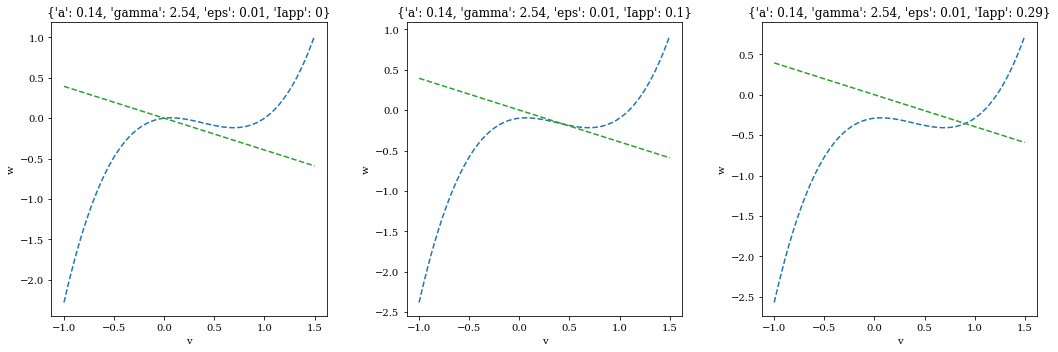

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

for i, par in enumerate(scenarios):
    plot_isocline(ax[i], **par)
    ax[i].set(xlabel='v', ylabel='w',
              title='{}'.format(par))
plt.tight_layout()
plt.savefig('img/fn1-py.pdf')

**Original fn**

In [23]:
scenariosd = [
     {"a":-.3, "b":1.4, "tau":20, "I":0},
     {"a":-.3, "b":1.4, "tau":20, "I":0.23},
     {"a":-.3, "b":1.4, "tau":20, "I":0.5}
]

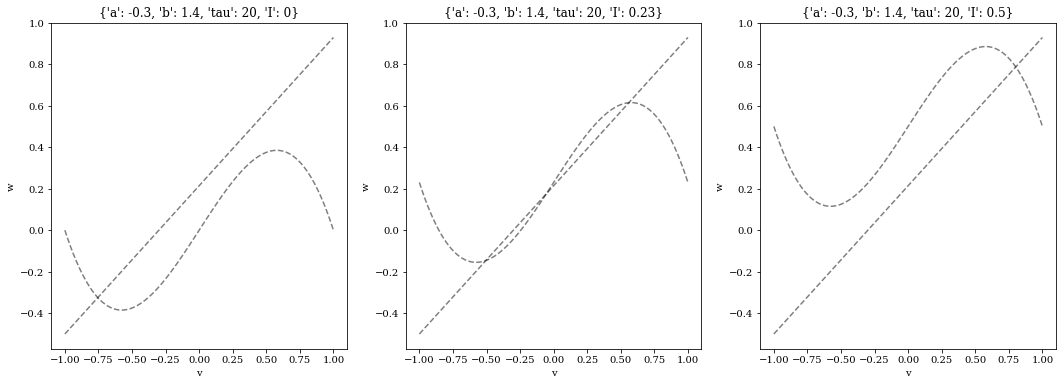

In [24]:
def plot_isocline(ax, a, b, tau, I, color='k', style='--', opacity=.5, vmin=-1,vmax=1):
    """Plot the null iscolines of the Fitzhugh nagumo system"""
    v = np.linspace(vmin,vmax,100)
    ax.plot(v, v - v**3 + I, style, color=color, alpha=opacity)
    ax.plot(v, (v - a)/b, style, color=color, alpha=opacity)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, sc in enumerate(scenariosd):
    plot_isocline(ax[i], **sc)
    ax[i].set(xlabel='v', ylabel='w',
              title='{}'.format(sc))
plt.savefig('img/fn2-py.pdf')

**Flow**

Flow is the vector field defined by: 

$$F: \mathbb R^2 \mapsto \mathbb R^2$$

$$\vec F(v,w) = \begin{bmatrix}\frac{dv}{dt}(v,w)\\  \frac{dw}{dt}(v,w)\end{bmatrix}$$

In [96]:
def plot_vector_field(ax, param, xrange, yrange, steps=50):
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    
    dx,dy = fitzhugh_nagumo([X,Y],0,**param)   
    
    ax.streamplot(X,Y,dx,dy, color=(0,0,0,.4))
    
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

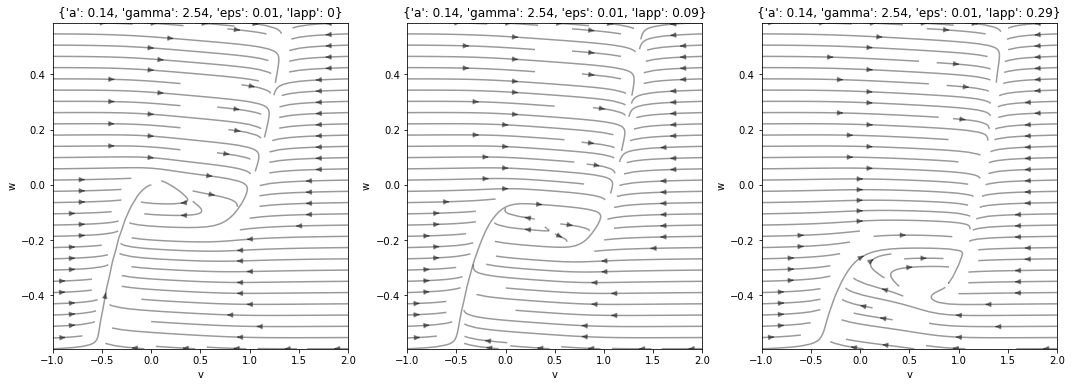

In [97]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, sc in enumerate(scenarios):
    xrange = (-1, 2)
    yrange = [(x/sc['gamma']) -0.2 for x in xrange] # with -0.2 the visualization improves
    plot_vector_field(ax[i], sc, xrange, yrange)
    ax[i].set(xlabel='v', ylabel='w',
          title='{}'.format(sc))

**Equilibrium points**

The equilibria are found at the crossing between the null-isocline for $v$ and the one for $w$.
$$F(v) = 0 = f(v) + \frac{v}{\gamma} - I_{app} = v^3 -v^2(a+1) -v(a + \frac{1}{\gamma}) - I_{app}$$

In [34]:
def find_roots(a,gamma,Iapp,eps):
    # The coeficients of the polynomial equation are:
    # 1           * v**3 
    # -(a+1)      * v**2 
    # -(a+1/g)    * v**1 
    # -Iapp       * v**0
    coef = [1, -(1+a), -(1/gamma + a), -Iapp]
    
    # We are only interested in real roots.
    # np.isreal(x) returns True only if x is real. 
    # The following line filter the list returned by np.roots
    # and only keep the real values. 
    roots = [np.real(r) for r in np.roots(coef) if np.isreal(r)]
    
    # We store the position of the equilibrium. 
    return [[r, f(r,a) - Iapp] for r in roots]

eqnproot = {}
for i, param in enumerate(scenarios):
    eqnproot[i] = find_roots(**param)

In [35]:
eqnproot

**Nature of equilibria**

The local behaviour and stability of the equilibrium is given by linearising the flow function. This is done using the Jacobian matrix of the flow:

$$
J \big \rvert_{v,w} = 
    \begin{bmatrix}
        \frac{ \partial F_1(v,w)}{\partial v} &  \frac{ \partial F_1(v,w)}{\partial w} \\
        \frac{ \partial F_2(v,w)}{\partial v} &  \frac{ \partial F_2(v,w)}{\partial w}
    \end{bmatrix} = - \begin{bmatrix}
        3v^2-2v(a+1)-a  &  1 \\
        -\epsilon  &  \epsilon\cdot\gamma 
    \end{bmatrix}
$$

In [36]:
import sympy 
sympy.init_printing()

# Define variable as symbols for sympy
v, w = sympy.symbols("v, w")
a, gamma, eps, Iapp = sympy.symbols("a, gamma, eps, Iapp")

# Symbolic expression of the system
dvdt = -(v**3-v**2*(a+1)-v*a)+w+Iapp
dwdt = eps*(-v-gamma*w)

# Symbolic expression of the matrix
sys = sympy.Matrix([dvdt, dwdt])
var = sympy.Matrix([v, w])
jac = sys.jacobian(var)

# You can convert jac to a function:
jacobian_fitznagumo_symbolic = sympy.lambdify((v, w, a, b, tau, I), jac, dummify=False)

#jacobian_fitznagumo = jacobian_fitznagumo_symbolic
jac

⎡       2                      ⎤
⎢a - 3⋅v  + 2⋅v⋅(a + 1)    1   ⎥
⎢                              ⎥
⎣         -eps           -eps⋅γ⎦

In [47]:
def jacobian_fitznagumo(v, w, a, gamma, Iapp, eps):
    """ Jacobian matrix of the ODE system modeling Fitzhugh-Nagumo's excitable system
    """
    return np.array([[a - 3*v**2 + 2*v*(a + 1),1],
                     [-eps, -eps*gamma]])

In [48]:
def stability(jacobian):
    """ Stability of the equilibrium given its associated 2x2 jacobian matrix. 
    Use the eigenvalues. 
    Args:
        jacobian (np.array 2x2): the jacobian matrix at the equilibrium point.
    Return:
        (string) status of equilibrium point.
    """
    
    eigv = np.linalg.eigvals(jacobian)
    
    
    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        nature = "Center" 
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        nature = "Saddle"
    else: 
        stability = 'Unstable' if all(np.real(eigv)>0) else 'Stable'
        nature = stability + (' focus' if all(np.imag(eigv)!=0) else ' node')
    return nature

In [49]:
eqstability = {}
for i, param in enumerate(scenarios):
    eqstability[i] = []
    for e in eqnproot[i]:
        J = jacobian_fitznagumo(e[0],e[1], **param)
        eqstability[i].append(stability(J))    

eqstability

{0: ['Stable node', 'Stable node', 'Unstable focus'],
 1: ['Stable node'],
 2: ['Stable node']}

In [66]:
eqnproot

In [67]:
eqstability

{0: ['Stable node', 'Stable node', 'Unstable focus'],
 1: ['Stable node'],
 2: ['Stable node']}

In [77]:
def plot_phase_diagram(param, ax=None, title=None):
    """Plot a complete Fitzhugh-Nagumo phase Diagram in ax.
    Including isoclines, flow vector field, equilibria and their stability"""
    if ax is None:
        ax = plt.gca()
    if title is None:
        title = "Phase space, {}".format(param) 
    
    ax.set(xlabel='v', ylabel='w', title=title)
        
    # Isocline and flow... 
    xlimit = (-1., 2.0)
    ylimit = (-.6, 1.6)
    plot_vector_field(ax, param, xlimit, ylimit)
    plot_isocline(ax, **param)
    
    # Plot the equilibria 
    eqnproot = find_roots(**param)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **param)) for e in eqnproot] 
    for e,n in zip(eqnproot,eqstability):
        ax.scatter(*e, color=EQUILIBRIUM_COLOR[n], s=80)
        
        # Show a small perturbation of the stable equilibria...
        time_span = np.linspace(0, 200, num=1500)
        if n[:6] == 'Stable':
            for perturb in (0.1, 0.6):
                ic = [e[0]+abs(perturb*e[0]),e[1]]
                traj = odeint(partial(fitzhugh_nagumo, **param),
                                                  y0=ic,
                                                  t=time_span)
                ax.plot(traj[:,0], traj[:,1])

    # Legend
    labels = frozenset(eqstability)
    #ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels, 
           #loc='lower right')

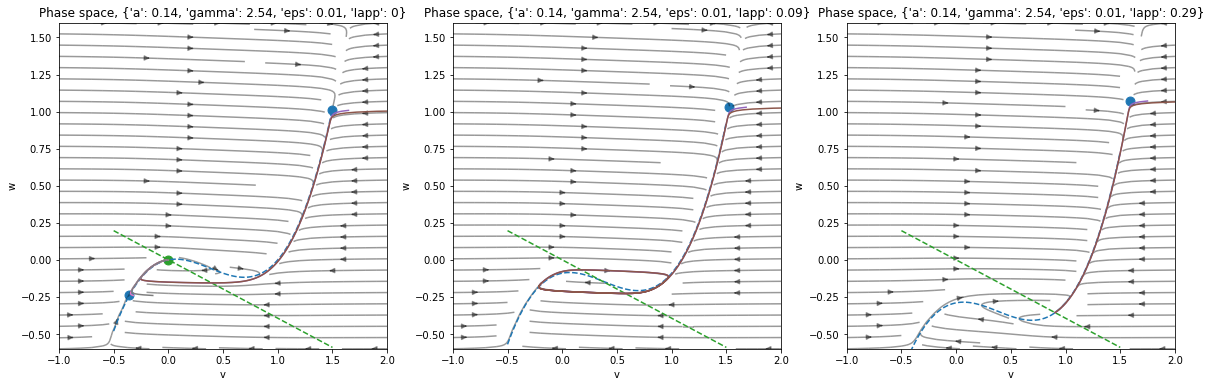

In [78]:
fig, ax = plt.subplots(1,3, figsize=(20, 6))
for i, param in enumerate(scenarios):
    plot_phase_diagram(param, ax[i])

In [55]:
EQUILIBRIUM_COLOR = {'Stable node':'C0',
                    'Unstable node':'C1', 
                    'Saddle':'C4',
                    'Stable focus':'C3',
                    'Unstable focus':'C2',
                    'Center':'C5'}